# Fake News Detection Project

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset


In [5]:
# Load both datasets
fake_df = pd.read_csv("data/Fake.csv")
true_df = pd.read_csv("data/True.csv")

# Assign labels: 0 for Fake, 1 for True
fake_df["label"] = 0
true_df["label"] = 1

# Merge datasets
df = pd.concat([fake_df, true_df], ignore_index=True)

# Shuffle to remove any ordering bias
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Create a single text column by combining title and body
df["text"] = df["title"] + " " + df["text"]

# Keep only the necessary columns
df = df[["text", "label"]]

# Preview the data
df.head()


,text,label
0,Ben Stein Calls Out 9th Circuit Court: Committ...,0
1,Trump drops Steve Bannon from National Securit...,1
2,Puerto Rico expects U.S. to lift Jones Act shi...,1
3,OOPS: Trump Just Accidentally Confirmed He Le...,0
4,Donald Trump heads for Scotland to reopen a go...,1


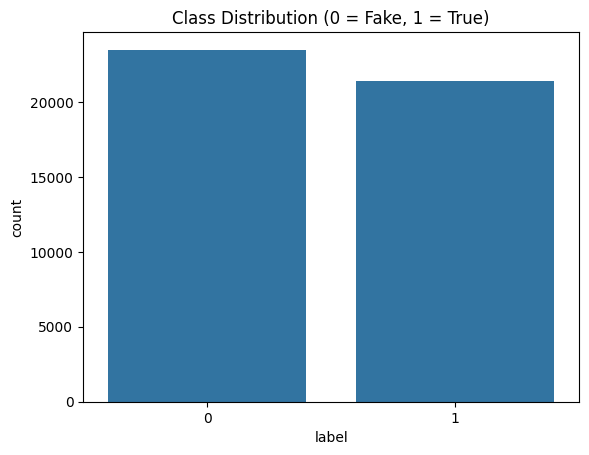

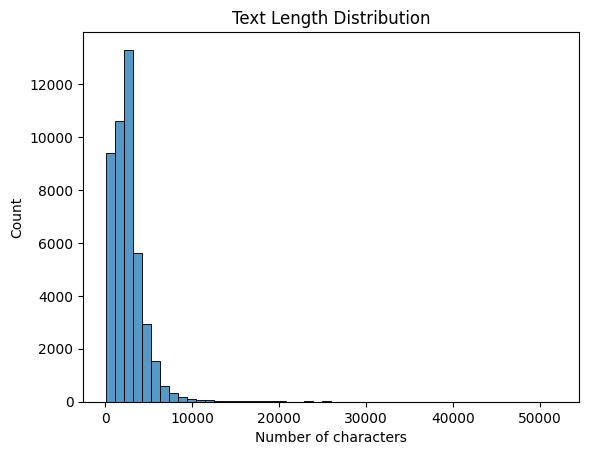

In [6]:
# Check label distribution
sns.countplot(data=df, x='label')
plt.title("Class Distribution (0 = Fake, 1 = True)")
plt.show()

# Text length distribution
df["text_len"] = df["text"].apply(len)
sns.histplot(df["text_len"], bins=50)
plt.title("Text Length Distribution")
plt.xlabel("Number of characters")
plt.show()


In [7]:
from sklearn.model_selection import train_test_split

# Split into training and test sets
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df["text"], df["label"], test_size=0.2, random_state=42
)

# Convert to Hugging Face Datasets
from datasets import Dataset

train_dataset = Dataset.from_dict({"text": train_texts, "label": train_labels})
test_dataset = Dataset.from_dict({"text": test_texts, "label": test_labels})


In [8]:
# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Tokenization function
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True, max_length=512)

# Apply to both train and test sets
train_dataset = train_dataset.map(tokenize, batched=True)
test_dataset = test_dataset.map(tokenize, batched=True)

# Format for PyTorch
train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])


Map: 100%|██████████| 8980/8980 [01:03<00:00, 140.39 examples/s]


In [9]:
from transformers import BertForSequenceClassification
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
from sklearn.metrics import accuracy_score
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc}

In [11]:
from transformers import TrainingArguments
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=1,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    use_cpu=True,
)

In [12]:
from transformers import Trainer

# Optional: Reduce dataset size
train_dataset = train_dataset.select(range(1000))  # Adjust based on len(train_dataset)
test_dataset = test_dataset.select(range(200))

# Update TrainingArguments for fewer epochs (if desired)
training_args.num_train_epochs = 1  # For testing

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

# Train
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.000300,0.035566,0.995000


TrainOutput(global_step=250, training_loss=0.08487229988072068, metrics={'train_runtime': 5066.8988, 'train_samples_per_second': 0.197, 'train_steps_per_second': 0.049, 'total_flos': 263111055360000.0, 'train_loss': 0.08487229988072068, 'epoch': 1.0})

In [13]:
eval_results = trainer.evaluate()
print(eval_results)

{'eval_loss': 0.03556572273373604, 'eval_accuracy': 0.995, 'eval_runtime': 84.4078, 'eval_samples_per_second': 2.369, 'eval_steps_per_second': 0.592, 'epoch': 1.0}


In [14]:
model.save_pretrained("./fine_tuned_bert")
tokenizer.save_pretrained("./fine_tuned_bert")

('./fine_tuned_bert\\tokenizer_config.json',
 './fine_tuned_bert\\special_tokens_map.json',
 './fine_tuned_bert\\vocab.txt',
 './fine_tuned_bert\\added_tokens.json')

In [15]:
import os
print(os.listdir("./fine_tuned_bert"))

['config.json', 'model.safetensors', 'special_tokens_map.json', 'tokenizer_config.json', 'vocab.txt']
